# Лабораторна робота №9

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import time
from numba import jit

In [2]:
import cupy as cp
print(cp.__version__)


13.6.0


In [3]:
print(cp.cuda.runtime.getDeviceCount())
print(cp.cuda.runtime.getDeviceProperties(0))

1
{'name': b'NVIDIA GeForce RTX 4080 Laptop GPU', 'totalGlobalMem': 12878086144, 'sharedMemPerBlock': 49152, 'regsPerBlock': 65536, 'warpSize': 32, 'maxThreadsPerBlock': 1024, 'maxThreadsDim': (1024, 1024, 64), 'maxGridSize': (2147483647, 65535, 65535), 'clockRate': 1665000, 'totalConstMem': 65536, 'major': 8, 'minor': 9, 'textureAlignment': 512, 'texturePitchAlignment': 32, 'multiProcessorCount': 58, 'kernelExecTimeoutEnabled': 1, 'integrated': 0, 'canMapHostMemory': 1, 'computeMode': 0, 'maxTexture1D': 131072, 'maxTexture2D': (131072, 65536), 'maxTexture3D': (16384, 16384, 16384), 'concurrentKernels': 1, 'ECCEnabled': 0, 'pciBusID': 1, 'pciDeviceID': 0, 'pciDomainID': 0, 'tccDriver': 0, 'memoryClockRate': 9001000, 'memoryBusWidth': 192, 'l2CacheSize': 50331648, 'maxThreadsPerMultiProcessor': 1536, 'isMultiGpuBoard': 0, 'cooperativeLaunch': 1, 'cooperativeMultiDeviceLaunch': 0, 'maxTexture1DMipmap': 32768, 'maxTexture1DLayered': (32768, 2048), 'maxTexture2DMipmap': (32768, 32768), 'ma

### Відновлення зображення

In [4]:
from poisson_tools import reconstruct_from_gradients, imread_rgb, imwrite_rgb

In [5]:
def compute_gradients(channel):
    """Обчислює градієнти (двох напрямків) для одного каналу зображення."""
    h, w = channel.shape

    gradx = np.zeros_like(channel, dtype=np.float64)
    grady = np.zeros_like(channel, dtype=np.float64)

    # forward differences
    gradx[:, :-1] = channel[:, 1:] - channel[:, :-1]
    grady[:-1, :] = channel[1:, :] - channel[:-1, :]

    return gradx, grady


# === Використання ===

# 1. Зчитуємо зображення
img = cv.imread("imgs/xxs_rat.jpg")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB).astype(np.float64)

# 2. Три канали
R = img[:,:,0]
G = img[:,:,1]
B = img[:,:,2]

# 3. Обчислюємо градієнти для кожного каналу
gradx_R, grady_R = compute_gradients(R)
gradx_G, grady_G = compute_gradients(G)
gradx_B, grady_B = compute_gradients(B)

# 4. Відновлюємо кожен канал з Poisson рівняння
R_rec = reconstruct_from_gradients(gradx_R, grady_R, R)
G_rec = reconstruct_from_gradients(gradx_G, grady_G, G)
B_rec = reconstruct_from_gradients(gradx_B, grady_B, B)

# 5. Формуємо результат
img_rec = np.stack([R_rec, G_rec, B_rec], axis=2)

img_rec = np.clip(img_rec, 0, 255).astype(np.uint8)

Reconstruction error (RMSE): 0.6836741675757301


Text(0.5, 1.0, 'reconstructed')

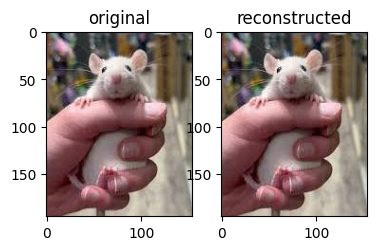

In [6]:
print("Reconstruction error (RMSE):", np.sqrt(np.mean((img_rec-img)**2)))
img = np.clip(0, 255, img).astype(np.uint8)
plt.subplot(1,3,1); plt.imshow(img, cmap='gray'); plt.title("original")
plt.subplot(1,3,2); plt.imshow(img_rec, cmap='gray'); plt.title("reconstructed")

### Створення маски

In [7]:
import cv2
import numpy as np

drawing = False
ix, iy = -1, -1
mask = None

def draw_mask(event, x, y, flags, param):
    global drawing, mask, ix, iy
    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        ix, iy = x, y
        cv2.circle(mask, (x,y), 8, 255, -1)

    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing:
            cv2.circle(mask, (x,y), 8, 255, -1)

    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        cv2.circle(mask, (x,y), 8, 255, -1)

def create_mask_interactive(image_path):
    global mask
    img = cv2.imread(image_path)
    mask = np.zeros(img.shape[:2], dtype=np.uint8)

    cv2.namedWindow("image")
    cv2.setMouseCallback("image", draw_mask)

    while True:
        vis = img.copy()
        vis[mask==255] = (0,255,0)

        cv2.imshow("image", vis)
        key = cv2.waitKey(1) & 0xFF

        if key == ord('q'):
            break

    cv2.destroyAllWindows()
    return mask > 0

# mask = create_mask_interactive("imgs/xxs_rat.jpg")
# cv2.imwrite("mask.png", mask.astype(np.uint8)*255)


### Безшовна вставка використовуючи cupy (GPU)

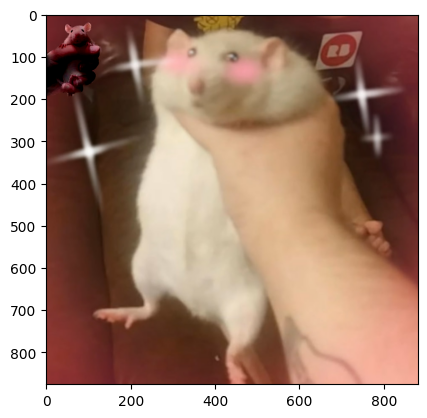

In [8]:
from poisson_tools import seamless_clone, imread_rgb, imwrite_rgb

src = imread_rgb("imgs/xxs_rat.jpg")
dst = imread_rgb("imgs/xxl_rat.jpg")

mask = cv2.imread("mask.png", cv2.IMREAD_GRAYSCALE) > 0
out = seamless_clone(src, dst, mask, offset=(0, 0))

plt.imshow(np.clip(0, 255, out).astype(np.uint8))

In [9]:
imwrite_rgb("out.png", out)

### Порівняння стероїдне застосування SciPy та метод Зейделя для безшовної вставки

In [10]:
@jit(nopython=True, fastmath=True)
def gauss_seidel_step(u, b, mask, h, w):
    diff = 0.0
    for y in range(1, h - 1):
        for x in range(1, w - 1):
            if mask[y, x]:
                old_val = u[y, x]
                
                # Сума 4-х сусідів
                neighbors_sum = u[y-1, x] + u[y+1, x] + u[y, x-1] + u[y, x+1]
                
                new_val = (neighbors_sum + b[y, x]) * 0.25
                
                u[y, x] = new_val
                diff += abs(new_val - old_val)
    return diff

def solve_gauss_seidel(src, dst, mask, offset, max_iter=2000, tol=1e-3):
    src_float = src.astype(np.float32)
    dst_float = dst.astype(np.float32)
    
    u = dst_float.copy()
    
    h_s, w_s = mask.shape
    y_off, x_off = offset
    
    mask_full = np.zeros(dst.shape[:2], dtype=bool)
    # Вставляємо маску на потрібне місце
    mask_full[y_off:y_off+h_s, x_off:x_off+w_s] = (mask > 0)
    
    mask_full[0, :] = False
    mask_full[-1, :] = False
    mask_full[:, 0] = False
    mask_full[:, -1] = False
    
    k = np.array([[0, -1, 0], 
                  [-1, 4, -1], 
                  [0, -1, 0]], dtype=np.float32)

    h_d, w_d, _ = dst.shape

    for ch in range(3):
        src_ch = src_float[:, :, ch]
        
        lap_s = cv2.filter2D(src_ch, -1, k)
        
        b_full = np.zeros((h_d, w_d), dtype=np.float32)
        b_full[y_off:y_off+h_s, x_off:x_off+w_s] = lap_s
        
        u_ch = u[:, :, ch]
        
        for i in range(max_iter):
            diff = gauss_seidel_step(u_ch, b_full, mask_full, h_d, w_d)
            if diff < tol:
                break
        u[:, :, ch] = u_ch

    return np.clip(u, 0, 255).astype(np.uint8)

Pixels     | Seidel (s) | SciPy (s) 
------------------------------------
157        | 0.3998     | 0.0860    
639        | 0.5340     | 0.0975    
2589       | 1.4772     | 0.1422    
5861       | 1.5732     | 0.1890    
10439      | 1.7218     | 0.3310    
16380      | 1.8990     | 0.4126    


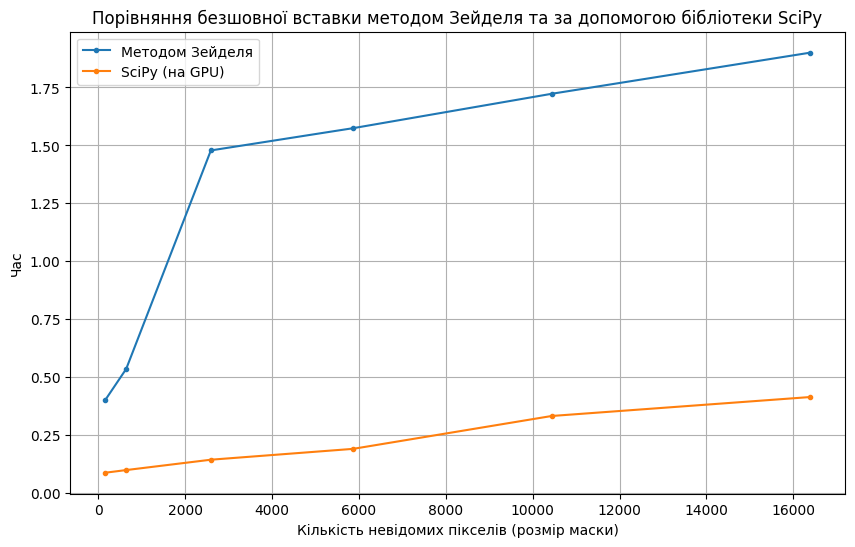

In [11]:
# Розміри для тестування (кількість пікселів у масці)
scales = [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
pixel_counts = []
times_seidel = []
times_scipy = []

print(f"{'Pixels':<10} | {'Seidel (s)':<10} | {'SciPy (s)':<10}")
print("-" * 36)

for s in scales:
    # Ресайз для зміни навантаження
    h, w = src.shape[:2]
    new_size = (int(w * s), int(h * s))
    
    src_s = cv2.resize(src, new_size)
    mask_s = cv2.resize(mask.astype(np.uint8), new_size) > 0
    
    # Кількість невідомих змінних (пікселів у масці)
    n_pixels = np.sum(mask_s)
    pixel_counts.append(n_pixels)
    
    # Тест Зейделя
    start = time.time()
    solve_gauss_seidel(src_s, dst, mask_s, (0,0))
    times_seidel.append(time.time() - start)
    
    # Тест SciPy
    start = time.time()
    seamless_clone(src_s, dst, mask_s, (0,0))
    times_scipy.append(time.time() - start)
    
    print(f"{n_pixels:<10} | {times_seidel[-1]:<10.4f} | {times_scipy[-1]:<10.4f}")

# Графіки
plt.figure(figsize=(10, 6))
plt.plot(pixel_counts, times_seidel, '.-', label='Методом Зейделя')
plt.plot(pixel_counts, times_scipy, '.-', label='SciPy (на GPU)')

plt.title('Порівняння безшовної вставки методом Зейделя та за допомогою бібліотеки SciPy')
plt.xlabel('Кількість невідомих пікселів (розмір маски)')
plt.ylabel('Час')
plt.grid(True,  ls="-")
plt.legend()

plt.savefig('benchmark_result.png')
plt.show()

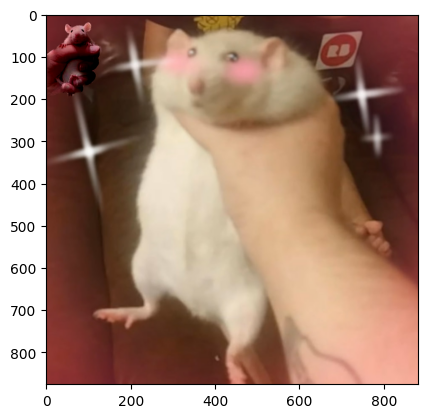

In [12]:
plt.imshow(solve_gauss_seidel(src, dst, mask, (0,0)))